# Train

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
DATA_PATH = "/kaggle/input/tweet-sentiment-extraction"

train_df = pd.read_csv(f"{DATA_PATH}/train.csv")
test_df  = pd.read_csv(f"{DATA_PATH}/test.csv")
print(train_df.shape, test_df.shape)
train_df.head()

(27481, 4) (3534, 3)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
import numpy as np
import re

def clean_text_light(s):
    if pd.isna(s):
        return ""
    return s.strip()

def clean_selected_text(s):
    if pd.isna(s):
        return ""
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

train_df["text"] = train_df["text"].astype(str).apply(clean_text_light)
train_df["selected_text"] = train_df["selected_text"].astype(str).apply(clean_selected_text)
test_df["text"] = test_df["text"].astype(str).apply(clean_text_light)


In [ ]:
train_df["text_len"] = train_df["text"].str.len()
train_df["sel_len"] = train_df["selected_text"].str.len()
train_df[["text", "selected_text", "text_len", "sel_len"]].head()

,text,selected_text,text_len,sel_len
0,"I`d have responded, if I were going","I`d have responded, if I were going",35,35
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,45,8
2,my boss is bullying me...,bullying me,25,11
3,what interview! leave me alone,leave me alone,30,14
4,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",74,13


In [ ]:
def find_selected_span(row):
    text = row["text"]
    selected = row["selected_text"]

    # nếu 2 chuỗi giống hệt, span = toàn bộ câu
    if text == selected:
        return 0, len(text)

    # tìm vị trí substring (có thể có nhiều, nên chọn cái nào Jaccard tốt nhất)
    idx = text.find(selected)
    if idx != -1:
        return idx, idx + len(selected)

    # Nếu không find được -> cố gắng nới lỏng chút (hay bị khi có space/thừa/kí tự đặc biệt)
    # Chiến lược đơn giản: lower-case, bỏ space dư
    text_low = text.lower()
    sel_low = selected.lower().strip()
    idx = text_low.find(sel_low)
    if idx != -1:
        return idx, idx + len(sel_low)

    # Nếu vẫn không tìm được, tạm trả -1 để sau dễ debug
    return -1, -1

# áp dụng
span_indices = train_df.apply(find_selected_span, axis=1)
train_df["char_start"] = span_indices.apply(lambda x: x[0])
train_df["char_end"] = span_indices.apply(lambda x: x[1])

# xem có bao nhiêu dòng bị lỗi (không tìm thấy selected_text trong text)
bad_rows = train_df[train_df["char_start"] == -1]
print("Số dòng không tìm được span:", len(bad_rows))


Số dòng không tìm được span: 0


In [ ]:
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df["sentiment"]
)

print("Train:", train_df.shape, "Valid:", valid_df.shape)

Train: (24732, 8) Valid: (2749, 8)


In [ ]:
train_df.head()

,textID,text,selected_text,sentiment,text_len,sel_len,char_start,char_end
10907,817350a9a1,Tried Nokia`s Ovi music store: 'Nokia Music do...,Tried Nokia`s Ovi music store: 'Nokia Music do...,neutral,135,135,0,135
20107,b2776c2690,I just filled out the forms to stop contributi...,I just filled out the forms to stop contributi...,neutral,137,137,0,137
23504,85dcce2756,is thinking what song to use for the next chil...,is thinking what song to use for the next chil...,neutral,64,64,0,64
22630,e75353b6d2,"in the words of liana corber: Moreover, WIAIH ...",decent,positive,108,6,96,102
17351,a86aefc3c2,Your second episode of Sonny WAC was on in New...,AMAZING!,positive,106,8,89,97


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def char_to_token_span(text, char_start, char_end, tokenizer, sentiment):
    encoded = tokenizer(
        sentiment,
        text,
        truncation=True,
        max_length=128,
        padding="max_length",
        return_offsets_mapping=True
    )

    offsets = encoded["offset_mapping"]
    seq_ids = encoded.sequence_ids()

    token_start = None
    token_end = None

    for i, (s, e) in enumerate(offsets):
        if seq_ids[i] != 1:
            continue
        if s is None or e is None:
            continue
        if s <= char_start < e:
            token_start = i
        if s < char_end <= e:
            token_end = i

    return encoded, token_start, token_end


In [ ]:
def add_token_spans(df):
    token_starts = []
    token_ends = []
    input_encodings = []

    for idx, row in df.iterrows():
        text = row["text"]
        sent = row["sentiment"]
        cs = row["char_start"]
        ce = row["char_end"]

        encoded, ts, te = char_to_token_span(text, cs, ce, tokenizer, sent)

        token_starts.append(ts)
        token_ends.append(te)
        input_encodings.append(encoded)

    df["token_start"] = token_starts
    df["token_end"] = token_ends
    df["encoded"] = input_encodings

    return df


In [ ]:
train_df = add_token_spans(train_df)
valid_df = add_token_spans(valid_df)

In [ ]:
train_df[["text", "selected_text", "token_start", "token_end"]].head()

,text,selected_text,token_start,token_end
10907,Tried Nokia`s Ovi music store: 'Nokia Music do...,Tried Nokia`s Ovi music store: 'Nokia Music do...,4,35
20107,I just filled out the forms to stop contributi...,I just filled out the forms to stop contributi...,4,31
23504,is thinking what song to use for the next chil...,is thinking what song to use for the next chil...,4,16
22630,"in the words of liana corber: Moreover, WIAIH ...",decent,29,29
17351,Your second episode of Sonny WAC was on in New...,AMAZING!,25,28


In [ ]:
print("None token_start train:", sum(t is None for t in train_df["token_start"]))
print("None token_end train:", sum(t is None for t in train_df["token_end"]))

print("None token_start valid:", sum(t is None for t in valid_df["token_start"]))
print("None token_end valid:", sum(t is None for t in valid_df["token_end"]))

None token_start train: 0
None token_end train: 0
None token_start valid: 0
None token_end valid: 0


In [ ]:
import torch
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, df):
        self.encodings = df["encoded"].tolist()
        self.starts = df["token_start"].tolist()
        self.ends = df["token_end"].tolist()

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        item = self.encodings[idx]
        start = self.starts[idx]
        end = self.ends[idx]

        encoding = {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            # RoBERTa không cần token_type_ids
            "start_positions": torch.tensor(start, dtype=torch.long),
            "end_positions": torch.tensor(end, dtype=torch.long),
        }

        return encoding

In [ ]:
train_dataset = TweetDataset(train_df)
valid_dataset = TweetDataset(valid_df)

In [ ]:
len(train_dataset), len(valid_dataset)

(24732, 2749)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [ ]:
batch = next(iter(train_loader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([16, 128])
attention_mask torch.Size([16, 128])
start_positions torch.Size([16])
end_positions torch.Size([16])


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class RobertaSpanModel(nn.Module):
    def __init__(self, model_name="roberta-base"):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        hidden = self.roberta.config.hidden_size

        self.dropout = nn.Dropout(0.1)
        self.start_classifier = nn.Linear(hidden, 1)
        self.end_classifier = nn.Linear(hidden, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        sequence_output = self.dropout(outputs.last_hidden_state)

        start_logits = self.start_classifier(sequence_output).squeeze(-1)
        end_logits = self.end_classifier(sequence_output).squeeze(-1)

        return start_logits, end_logits

In [ ]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c) + 1e-15)

In [ ]:
def decode_span(text, start_idx, end_idx, offsets):
    if start_idx is None or end_idx is None:
        return text  # fallback

    start_char = offsets[start_idx][0]
    end_char = offsets[end_idx][1]
    return text[start_char:end_char]


In [ ]:
def validate(model, loader, df):
    model.eval()
    scores = []
    sample_idx = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            start_logits, end_logits = model(input_ids, attention_mask)
            pred_start = start_logits.argmax(dim=1).cpu().numpy()
            pred_end = end_logits.argmax(dim=1).cpu().numpy()

            for i in range(len(pred_start)):
                row = df.iloc[sample_idx]
                text = row.text
                offsets = row.encoded["offset_mapping"]

                # Safety checks
                if pred_end[i] < pred_start[i]:
                    pred_end[i] = pred_start[i]

                if pred_start[i] >= len(offsets) or pred_end[i] >= len(offsets):
                    pred_text = text
                else:
                    pred_text = decode_span(
                        text,
                        pred_start[i],
                        pred_end[i],
                        offsets
                    )

                # Neutral rule
                if row.sentiment == "neutral":
                    pred_text = text

                score = jaccard(row.selected_text, pred_text)
                scores.append(score)

                sample_idx += 1

    return sum(scores) / len(scores)

In [ ]:
print(train_df[['text','selected_text','char_start','char_end','token_start','token_end']].sample(5))


                                                    text selected_text  \
26645                                         follow me!    follow me!   
1314   you could say that. I left it in VT and have b...      I`m lost   
21477  well I hovered over the button LOL NOT - sleep...       welcome   
2602   I know! I`m so slow its horrible. DON`T TELL O...     horrible.   
13854  i know.. i suck.. i`m a master procrastinator ...       i suck.   

       char_start  char_end  token_start  token_end  
26645           0        10            4          6  
1314           86        94           24         27  
21477          69        76           20         20  
2602           24        33           13         14  
13854           9        16            7          9  


In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaSpanModel().to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*num_training_steps),
    num_training_steps=num_training_steps
)



In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-1, label_smoothing=0.1)

best_jaccard = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    print(f"\n===== START EPOCH {epoch+1} =====")

    for step, batch in enumerate(train_loader):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_pos = batch["start_positions"].to(device)
        end_pos = batch["end_positions"].to(device)

        optimizer.zero_grad()

        start_logits, end_logits = model(input_ids, attention_mask)
        loss = loss_fn(start_logits, start_pos) + loss_fn(end_logits, end_pos)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # DEBUG PRINT EVERY 100 BATCHES
        if step % 100 == 0:
            print(f"Epoch {epoch+1} | Step {step}/{len(train_loader)} | Loss: {loss.item():.4f}", flush=True)

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - AVG Loss: {avg_loss:.4f}", flush=True)

    # VALIDATION
    val_jaccard = validate(model, valid_loader, valid_df)
    print(f"Validation Jaccard: {val_jaccard:.4f}", flush=True)
    if val_jaccard > best_jaccard:
        best_jaccard = val_jaccard
        torch.save(model.state_dict(), "best_roberta_span.pt")
        print("New BEST model saved:", best_jaccard)


===== START EPOCH 1 =====
Epoch 1 | Step 0/1546 | Loss: 9.6679
Epoch 1 | Step 100/1546 | Loss: 6.0124
Epoch 1 | Step 200/1546 | Loss: 4.9506
Epoch 1 | Step 300/1546 | Loss: 4.1618
Epoch 1 | Step 400/1546 | Loss: 4.2348
Epoch 1 | Step 500/1546 | Loss: 2.9897
Epoch 1 | Step 600/1546 | Loss: 3.5676
Epoch 1 | Step 700/1546 | Loss: 3.2887
Epoch 1 | Step 800/1546 | Loss: 3.7730
Epoch 1 | Step 900/1546 | Loss: 2.7415
Epoch 1 | Step 1000/1546 | Loss: 2.5772
Epoch 1 | Step 1100/1546 | Loss: 2.8053
Epoch 1 | Step 1200/1546 | Loss: 3.0237
Epoch 1 | Step 1300/1546 | Loss: 3.3996
Epoch 1 | Step 1400/1546 | Loss: 3.0375
Epoch 1 | Step 1500/1546 | Loss: 2.5656
Epoch 1/3 - AVG Loss: 3.8074
Validation Jaccard: 0.6931
New BEST model saved: 0.6930893112116753

===== START EPOCH 2 =====
Epoch 2 | Step 0/1546 | Loss: 3.3994
Epoch 2 | Step 100/1546 | Loss: 3.5494
Epoch 2 | Step 200/1546 | Loss: 3.6196
Epoch 2 | Step 300/1546 | Loss: 3.2670
Epoch 2 | Step 400/1546 | Loss: 2.9867
Epoch 2 | Step 500/1546 | Lo

In [ ]:
model = RobertaSpanModel().to(device)
model.load_state_dict(torch.load("/kaggle/working/best_roberta_span.pt", map_location=device))
model.eval()

In [ ]:
def decode_span(text, start_idx, end_idx, offsets):
    if start_idx is None or end_idx is None:
        return text
    start_char = offsets[start_idx][0]
    end_char = offsets[end_idx][1]
    return text[start_char:end_char]

In [ ]:
for idx in range(10):
    sample = test_df.iloc[idx]

    text = sample.text
    sent = sample.sentiment

    enc = tokenizer(
        sent,
        text,
        truncation=True,
        max_length=128,
        padding="max_length",
        return_offsets_mapping=True
    )

    input_ids = torch.tensor([enc["input_ids"]]).to(device)
    attn = torch.tensor([enc["attention_mask"]]).to(device)

    with torch.no_grad():
        start_logits, end_logits = model(input_ids, attn)

    ps = start_logits.argmax(-1).item()
    pe = end_logits.argmax(-1).item()

    pred = decode_span(text, ps, pe, enc["offset_mapping"])

    print("========== SAMPLE", idx, "==========")
    print("Sentiment:", sent)
    print("TEXT:", text)
    print("PRED:", pred)
    print()

========== SAMPLE 0 ==========
Sentiment: neutral
TEXT: Last session of the day http://twitpic.com/67ezh
PRED: Last session of the day

========== SAMPLE 1 ==========
Sentiment: positive
TEXT: Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).
PRED: exciting

========== SAMPLE 2 ==========
Sentiment: negative
TEXT: Recession hit Veronique Branquinho, she has to quit her company, such a shame!
PRED: such a shame!

========== SAMPLE 3 ==========
Sentiment: positive
TEXT: happy bday!
PRED: happy

========== SAMPLE 4 ==========
Sentiment: positive
TEXT: http://twitpic.com/4w75p - I like it!!
PRED: I like

========== SAMPLE 5 ==========
Sentiment: positive
TEXT: that`s great!! weee!! visitors!
PRED: that`s great!!

========== SAMPLE 6 ==========
Sentiment: negative
TEXT: I THINK EVERYONE HATES ME ON HERE lol
PRED: HATES

========== SAMPLE 7 ==========
Sentiment: negative
TEXT: soooooo wish i could, but im in school and myspace is completely 

# Train

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
DATA_PATH = "/kaggle/input/tweet-sentiment-extraction"

train_df = pd.read_csv(f"{DATA_PATH}/train.csv")
test_df  = pd.read_csv(f"{DATA_PATH}/test.csv")
print(train_df.shape, test_df.shape)
train_df.head()

(27481, 4) (3534, 3)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
import numpy as np
import re

def clean_text_safe(s):
    if pd.isna(s):
        return ""
    s = s.strip()
    return s


train_df["text"] = train_df["text"].astype(str).apply(clean_text_safe)
train_df["selected_text"] = train_df["selected_text"].astype(str).apply(clean_text_safe)
test_df["text"] = test_df["text"].astype(str).apply(clean_text_safe)

In [ ]:
train_df["text_len"] = train_df["text"].str.len()
train_df["sel_len"] = train_df["selected_text"].str.len()
train_df[["text", "selected_text", "text_len", "sel_len"]].head()

,text,selected_text,text_len,sel_len
0,"I`d have responded, if I were going","I`d have responded, if I were going",35,35
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,45,8
2,my boss is bullying me...,bullying me,25,11
3,what interview! leave me alone,leave me alone,30,14
4,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",74,13


In [ ]:
def find_selected_span_robust(row):
    text = row["text"]
    selected = row["selected_text"]

    if text == selected:
        return 0, len(text)

    text_lower = text.lower()
    selected_lower = selected.lower().strip()

    # 1. Tìm trực tiếp
    idx = text_lower.find(selected_lower)
    if idx != -1:
        return idx, idx + len(selected_lower)

    # 2. Thử remove double space trong text
    text2 = re.sub(r"\s+", " ", text_lower)
    idx = text2.find(selected_lower)
    if idx != -1:
        real_idx = text_lower.find(selected_lower[:5])
        if real_idx != -1:
            return real_idx, real_idx + len(selected)

    # 3. Matching sliding window theo token (fallback)
    best_score = 0
    best_span = (0, 0)
    for i in range(len(text_lower)):
        for j in range(i+1, min(i+100, len(text_lower))):
            substr = text_lower[i:j]
            score = len(set(substr.split()) & set(selected_lower.split()))
            if score > best_score:
                best_score = score
                best_span = (i, j)

    if best_score > 0:
        return best_span

    return -1, -1


span_indices = train_df.apply(find_selected_span_robust, axis=1)
train_df["char_start"] = span_indices.apply(lambda x: x[0])
train_df["char_end"] = span_indices.apply(lambda x: x[1])

print("Số dòng không tìm được span:", (train_df["char_start"] == -1).sum())

Số dòng không tìm được span: 0


In [ ]:
full_df = train_df.copy()
train_df = full_df

print("Training data:", train_df.shape)

Training data: (27481, 8)


In [ ]:
train_df.head()

,textID,text,selected_text,sentiment,text_len,sel_len,char_start,char_end
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,35,0,35
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,45,8,0,8
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,11,22
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,16,30
4,358bd9e861,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",negative,74,13,0,13


In [ ]:
for i in range(5):
    row = train_df.iloc[i]
    span = row.text[row.char_start:row.char_end]
    print("TEXT:", row.text)
    print("SELECTED:", row.selected_text)
    print("SPAN:", span)
    print("-"*40)


TEXT: I`d have responded, if I were going
SELECTED: I`d have responded, if I were going
SPAN: I`d have responded, if I were going
----------------------------------------
TEXT: Sooo SAD I will miss you here in San Diego!!!
SELECTED: Sooo SAD
SPAN: Sooo SAD
----------------------------------------
TEXT: my boss is bullying me...
SELECTED: bullying me
SPAN: bullying me
----------------------------------------
TEXT: what interview! leave me alone
SELECTED: leave me alone
SPAN: leave me alone
----------------------------------------
TEXT: Sons of ****, why couldn`t they put them on the releases we already bought
SELECTED: Sons of ****,
SPAN: Sons of ****,
----------------------------------------


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def char_to_token_span(text, char_start, char_end, tokenizer, sentiment):
    encoded = tokenizer(
        sentiment,
        text,
        truncation=True,
        max_length=128,
        padding="max_length",
        return_offsets_mapping=True
    )

    offsets = encoded["offset_mapping"]
    seq_ids = encoded.sequence_ids()

    token_start = None
    token_end = None

    for i, (s, e) in enumerate(offsets):
        if seq_ids[i] != 1:
            continue
        if s is None or e is None:
            continue
        if s <= char_start < e:
            token_start = i
        if s < char_end <= e:
            token_end = i

    return encoded, token_start, token_end


In [ ]:
def add_token_spans(df):
    token_starts = []
    token_ends = []
    input_encodings = []

    for idx, row in df.iterrows():
        text = row["text"]
        sent = row["sentiment"]
        cs = row["char_start"]
        ce = row["char_end"]

        encoded, ts, te = char_to_token_span(text, cs, ce, tokenizer, sent)

        token_starts.append(ts)
        token_ends.append(te)
        input_encodings.append(encoded)

    df["token_start"] = token_starts
    df["token_end"] = token_ends
    df["encoded"] = input_encodings

    return df


In [ ]:
train_df = add_token_spans(train_df)

In [ ]:
train_df[["text", "selected_text", "token_start", "token_end"]].head()

,text,selected_text,token_start,token_end
0,"I`d have responded, if I were going","I`d have responded, if I were going",4,13
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,4,7
2,my boss is bullying me...,bullying me,7,8
3,what interview! leave me alone,leave me alone,7,9
4,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",4,8


In [ ]:
print("None token_start train:", sum(t is None for t in train_df["token_start"]))
print("None token_end train:", sum(t is None for t in train_df["token_end"]))

None token_start train: 0
None token_end train: 0


In [ ]:
pd.set_option('display.max_colwidth', 2)

for idx, row in train_df.head(3).iterrows():
    offsets = row["encoded"]["offset_mapping"]
    ts = row["token_start"]
    te = row["token_end"]

    if ts is None or te is None or ts == -1 or te == -1:
        decoded = "SPAN NOT FOUND"
    else:
        start_char = offsets[ts][0]
        end_char = offsets[te][1]
        decoded = row.text[start_char:end_char]

    print(f"ROW INDEX: {idx}")
    print("TEXT:", row.text)
    print("SELECTED:", row.selected_text)
    print("DECODED FROM TOKENS:", decoded)
    print("-"*60)


ROW INDEX: 0
TEXT: I`d have responded, if I were going
SELECTED: I`d have responded, if I were going
DECODED FROM TOKENS: I`d have responded, if I were going
------------------------------------------------------------
ROW INDEX: 1
TEXT: Sooo SAD I will miss you here in San Diego!!!
SELECTED: Sooo SAD
DECODED FROM TOKENS: Sooo SAD
------------------------------------------------------------
ROW INDEX: 2
TEXT: my boss is bullying me...
SELECTED: bullying me
DECODED FROM TOKENS: bullying me
------------------------------------------------------------


In [ ]:
import torch
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, df):
        self.encodings = df["encoded"].tolist()
        self.starts = df["token_start"].tolist()
        self.ends = df["token_end"].tolist()

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        item = self.encodings[idx]
        start = self.starts[idx]
        end = self.ends[idx]

        encoding = {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            # RoBERTa không cần token_type_ids
            "start_positions": torch.tensor(start, dtype=torch.long),
            "end_positions": torch.tensor(end, dtype=torch.long),
        }

        return encoding

In [ ]:
train_dataset = TweetDataset(train_df)

In [ ]:
len(train_dataset)

27481

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
batch = next(iter(train_loader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([16, 128])
attention_mask torch.Size([16, 128])
start_positions torch.Size([16])
end_positions torch.Size([16])


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class RobertaSpanModel(nn.Module):
    def __init__(self, model_name="roberta-base"):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        hidden = self.roberta.config.hidden_size

        self.dropout = nn.Dropout(0.1)
        self.start_classifier = nn.Linear(hidden, 1)
        self.end_classifier = nn.Linear(hidden, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        sequence_output = self.dropout(outputs.last_hidden_state)

        start_logits = self.start_classifier(sequence_output).squeeze(-1)
        end_logits = self.end_classifier(sequence_output).squeeze(-1)

        return start_logits, end_logits

In [ ]:
print(train_df[['text','selected_text','char_start','char_end','token_start','token_end']].sample(5))

                                                                                                                 text  \
6467   Looks like rain again  Oh well, it will give me a chance to work on a new crochet pattern I have in the works.   
19988  very familiar.....sorry you`re feeling that way                                                                  
26182  so happy its friday...not so happy about this rain                                                               
6830   Yes, sir!   See here http://is.gd/wz2K                                                                           
25762  now i dont feel so good                                                                                          

                 selected_text  char_start  char_end  token_start  token_end  
6467   give me a chance         40          56        14           17         
19988  .sorry                   17          23        6            7          
26182  happy                    3   

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaSpanModel().to(device)
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = num_epochs * len(train_loader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*num_training_steps),
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ================== SET SEED (ĐỔI SỐ MỖI LẦN TRAIN) ==================
SEED = 42   # ĐỔI: 42 -> 123 -> 999 cho các lần train khác

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# ================== MODEL + OPTIMIZER ==================
loss_fn = nn.CrossEntropyLoss()
model.train()


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    print(f"\n===== EPOCH {epoch+1}/{num_epochs} =====")

    for step, batch in enumerate(train_loader):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_pos = batch["start_positions"].to(device)
        end_pos = batch["end_positions"].to(device)

        optimizer.zero_grad()

        start_logits, end_logits = model(input_ids, attention_mask)
        loss = loss_fn(start_logits, start_pos) + loss_fn(end_logits, end_pos)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        if step % 100 == 0:
            print(
                f"Epoch {epoch+1} | Step {step}/{len(train_loader)} "
                f"| Loss: {loss.item():.4f}"
            )

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - AVG Loss: {avg_loss:.4f}")


===== EPOCH 1/3 =====
Epoch 1 | Step 0/1718 | Loss: 9.7491
Epoch 1 | Step 100/1718 | Loss: 5.6244
Epoch 1 | Step 200/1718 | Loss: 2.7836
Epoch 1 | Step 300/1718 | Loss: 2.3207
Epoch 1 | Step 400/1718 | Loss: 2.6585
Epoch 1 | Step 500/1718 | Loss: 1.5905
Epoch 1 | Step 600/1718 | Loss: 1.7285
Epoch 1 | Step 700/1718 | Loss: 1.4214
Epoch 1 | Step 800/1718 | Loss: 0.8427
Epoch 1 | Step 900/1718 | Loss: 1.2676
Epoch 1 | Step 1000/1718 | Loss: 2.1941
Epoch 1 | Step 1100/1718 | Loss: 1.1719
Epoch 1 | Step 1200/1718 | Loss: 1.8153
Epoch 1 | Step 1300/1718 | Loss: 1.3222
Epoch 1 | Step 1400/1718 | Loss: 1.4394
Epoch 1 | Step 1500/1718 | Loss: 1.5815
Epoch 1 | Step 1600/1718 | Loss: 1.5935
Epoch 1 | Step 1700/1718 | Loss: 2.2523
Epoch 1 - AVG Loss: 2.5133

===== EPOCH 2/3 =====
Epoch 2 | Step 0/1718 | Loss: 1.4007
Epoch 2 | Step 100/1718 | Loss: 1.0816
Epoch 2 | Step 200/1718 | Loss: 1.7137
Epoch 2 | Step 300/1718 | Loss: 1.5622
Epoch 2 | Step 400/1718 | Loss: 1.8800
Epoch 2 | Step 500/1718 | 

In [ ]:
# ================== SAVE MODEL ==================
model_path = f"robertaV2.pt"
torch.save(model.state_dict(), model_path)
print(f"\nMODEL SAVED: {model_path}")


MODEL SAVED: robertaV2.pt


In [ ]:
model = RobertaSpanModel().to(device)
model.load_state_dict(torch.load("/kaggle/working/robertaV2.pt", map_location=device))
model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaSpanModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

# Ensemble

In [ ]:
model1 = RobertaSpanModel().to(device)
model2 = RobertaSpanModel().to(device)

model1.load_state_dict(torch.load("/kaggle/input/last-epoch-mode/last_epoch_model.pt"))
model2.load_state_dict(torch.load("/kaggle/input/robertav2/robertaV2.pt"))

model1.eval()
model2.eval()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaSpanModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [ ]:
def decode_span(text, start_idx, end_idx, offsets):

    if start_idx is None or end_idx is None:
        return text
    if start_idx < 0 or end_idx >= len(offsets):
        return text
    if end_idx < start_idx:
        end_idx = start_idx

    start_char = offsets[start_idx][0]
    end_char = offsets[end_idx][1]

    if start_char is None or end_char is None:
        return text

    pred = text[start_char:end_char]

    # Nếu kết quả rỗng → fallback
    if pred.strip() == "":
        return text

    return pred

In [ ]:
def pp(filtered_output, real_tweet):
    filtered_output = ' '.join(filtered_output.split())
    if len(real_tweet.split()) < 2:
        filtered_output = real_tweet
    else:
        if len(filtered_output.split()) == 1:
            if filtered_output.endswith(".."):
                if real_tweet.startswith(" "):
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\.)\1{2,}', '', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\.)\1{2,}', '.', filtered_output)
                else:
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\.)\1{2,}', '.', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\.)\1{2,}', '..', filtered_output)
                return filtered_output
            if filtered_output.endswith('!!'):
                if real_tweet.startswith(" "):
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\!)\1{2,}', '', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!', filtered_output)
                else:
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!!', filtered_output)
                return filtered_output

        if real_tweet.startswith(" "):
            filtered_output = filtered_output.strip()
            text_annotetor = ' '.join(real_tweet.split())
            start = text_annotetor.find(filtered_output)
            end = start + len(filtered_output)
            start -= 0
            end += 2
            flag = real_tweet.find("  ")
            if flag < start:
                filtered_output = real_tweet[start:end]

        if "  " in real_tweet and not real_tweet.startswith(" "):
            filtered_output = filtered_output.strip()
            text_annotetor = re.sub(" {2,}", " ", real_tweet)
            start = text_annotetor.find(filtered_output)
            end = start + len(filtered_output)
            start -= 0
            end += 2
            flag = real_tweet.find("  ")
            if flag < start:
                filtered_output = real_tweet[start:end]
    return filtered_output


In [ ]:
preds = []

for row in test_df.itertuples():
    text = row.text
    sent = row.sentiment

    enc = tokenizer(
        sent,
        text,
        truncation=True,
        max_length=128,
        padding="max_length",
        return_offsets_mapping=True
    )

    input_ids = torch.tensor([enc["input_ids"]]).to(device)
    attn = torch.tensor([enc["attention_mask"]]).to(device)

    with torch.no_grad():
        s1, e1 = model1(input_ids, attn)
        s2, e2 = model2(input_ids, attn)

    # ENSEMBLE
    alpha = 0.75  # ưu tiên model2

    start_logits = alpha * s2 + (1 - alpha) * s1
    end_logits   = alpha * e2 + (1 - alpha) * e1


    ps = start_logits.argmax(-1).item()
    pe = end_logits.argmax(-1).item()

    pred = decode_span(text, ps, pe, enc["offset_mapping"])

    # Neutral rule
    if sent == "neutral":
        pred = text
    else:
        pred = pp(pred, text)

    preds.append(pred)

# Create submission
submission = pd.DataFrame({
    "textID": test_df["textID"],
    "selected_text": preds
})

submission.to_csv("submission.csv", index=False)

print("File 'submission.csv' đã được tạo!")
submission.head()

File 'submission.csv' đã được tạo!


,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting
2,eee518ae67,shame!
3,01082688c6,happy bday!
4,33987a8ee5,I like it!!


# Reranking

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model1 = RobertaSpanModel().to(device)
model2 = RobertaSpanModel().to(device)

model1.load_state_dict(torch.load("/kaggle/input/last-epoch-mode/last_epoch_model.pt"))
model2.load_state_dict(torch.load("/kaggle/input/robertav2/robertaV2.pt"))

model1.eval()
model2.eval()

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaSpanModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
DATA_PATH = "/kaggle/input/tweet-sentiment-extraction"

train_df = pd.read_csv(f"{DATA_PATH}/train.csv")
test_df  = pd.read_csv(f"{DATA_PATH}/test.csv")
print(train_df.shape, test_df.shape)
train_df.head()

(27481, 4) (3534, 3)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
import numpy as np
import re

def clean_text_safe(s):
    if pd.isna(s):
        return ""
    s = s.strip()
    return s
train_df["text"] = train_df["text"].astype(str).apply(clean_text_safe)
train_df["selected_text"] = train_df["selected_text"].astype(str).apply(clean_text_safe)
test_df["text"] = test_df["text"].astype(str).apply(clean_text_safe)

In [ ]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    if len(a) == 0 and len(b) == 0:
        return 1.0
    return float(len(a & b)) / len(a | b)


In [ ]:
def decode_span(text, start_idx, end_idx, offsets):

    if start_idx is None or end_idx is None:
        return text
    if start_idx < 0 or end_idx >= len(offsets):
        return text
    if end_idx < start_idx:
        end_idx = start_idx

    start_char = offsets[start_idx][0]
    end_char = offsets[end_idx][1]

    if start_char is None or end_char is None:
        return text

    pred = text[start_char:end_char]

    # Nếu kết quả rỗng → fallback
    if pred.strip() == "":
        return text

    return pred

In [ ]:
def generate_top_n_spans_ensemble(text, sentiment, model1, model2, tokenizer, n=5):
    model1.eval()
    model2.eval()

    enc = tokenizer(
        sentiment,
        text,
        truncation=True,
        max_length=128,
        padding="max_length",
        return_offsets_mapping=True
    )

    input_ids = torch.tensor([enc["input_ids"]]).to(device)
    attn = torch.tensor([enc["attention_mask"]]).to(device)

    with torch.no_grad():
        s1, e1 = model1(input_ids, attn)
        s2, e2 = model2(input_ids, attn)

    # Ensemble logits (có thể chỉnh alpha nếu muốn)
    alpha = 0.75  # ưu tiên model2
    start_logits = alpha * s2 + (1 - alpha) * s1
    end_logits   = alpha * e2 + (1 - alpha) * e1

    start_prob = torch.softmax(start_logits, dim=1)[0]
    end_prob   = torch.softmax(end_logits, dim=1)[0]

    start_top = torch.topk(start_prob, n).indices
    end_top   = torch.topk(end_prob, n).indices

    spans = {}

    for s in start_top:
        for e in end_top:
            if e >= s and e - s < 20:
                span = decode_span(text, s.item(), e.item(), enc["offset_mapping"])
                score = (start_prob[s] + end_prob[e]).item()

                # Tránh span bị trùng → giữ điểm cao nhất
                if span not in spans or spans[span] < score:
                    spans[span] = score

    spans = sorted(spans.items(), key=lambda x: x[1], reverse=True)
    return spans[:n]

In [ ]:
rerank_data = []

for idx, row in train_df.iterrows():
    text = row.text
    sent = row.sentiment
    gt = row.selected_text

    candidates = generate_top_n_spans_ensemble(
        text, sent, model1, model2, tokenizer, n=5
    )

    for span, base_score in candidates:
        rerank_data.append({
            "text": text,
            "sentiment": sent,
            "candidate": span,
            "base_score": base_score,
            "jaccard": jaccard(span, gt)
        })

rerank_df = pd.DataFrame(rerank_data)
rerank_df.to_csv("rerank_train.csv", index=False)

In [ ]:
rerank_df = pd.read_csv("rerank_train.csv")
print(rerank_df.shape)
rerank_df.head(10)


(136616, 5)


,text,sentiment,candidate,base_score,jaccard
0,"I`d have responded, if I were going",neutral,"I`d have responded, if I were going",1.998756,1.000000
1,"I`d have responded, if I were going",neutral,"I`d have responded,",1.000430,0.428571
2,"I`d have responded, if I were going",neutral,"I`d have responded, if I were",0.999887,0.857143
3,"I`d have responded, if I were going",neutral,"I`d have responded, if",0.999848,0.571429
4,"I`d have responded, if I were going",neutral,I,0.999845,0.142857
5,Sooo SAD I will miss you here in San Diego!!!,negative,Sooo SAD,1.351530,1.000000
6,Sooo SAD I will miss you here in San Diego!!!,negative,SAD,1.119102,0.500000
7,Sooo SAD I will miss you here in San Diego!!!,negative,ooo SAD,0.761564,0.333333
8,Sooo SAD I will miss you here in San Diego!!!,negative,Sooo SAD I will miss you here in San Diego!!!,0.734349,0.200000
9,Sooo SAD I will miss you here in San Diego!!!,negative,Sooo SAD I will miss,0.636720,0.400000


In [ ]:
from torch.utils.data import Dataset
import torch

class RerankDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer

        # Ép kiểu + xử lý NaN để tránh lỗi
        self.texts = df["text"].fillna("").astype(str).tolist()
        self.sentiments = df["sentiment"].fillna("").astype(str).tolist()
        self.candidates = df["candidate"].fillna("").astype(str).tolist()
        self.labels = df["jaccard"].fillna(0).tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):

        combined = (
            self.sentiments[idx] + " " +
            self.texts[idx] + " [SEP] " +
            self.candidates[idx]
        )

        enc = self.tokenizer(
            combined,
            truncation=True,
            max_length=128,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [ ]:
import torch.nn as nn
from transformers import AutoModel
from torch.utils.data import DataLoader
class RobertaRerankModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = AutoModel.from_pretrained("roberta-base")
        self.fc = nn.Linear(self.roberta.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        return self.fc(cls).squeeze(-1)


In [ ]:
rerank_dataset = RerankDataset(rerank_df, tokenizer)
rerank_loader = DataLoader(rerank_dataset, batch_size=16, shuffle=True)

rerank_model = RobertaRerankModel().to(device)
optimizer = torch.optim.AdamW(rerank_model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

for epoch in range(3):
    rerank_model.train()
    total_loss = 0

    for step, batch in enumerate(rerank_loader):
        optimizer.zero_grad()

        outputs = rerank_model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        ).squeeze()

        loss = loss_fn(outputs, batch["label"].to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 200 == 0:
            print(f"Epoch {epoch+1} | Step {step} | Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} AVG Loss: {total_loss / len(rerank_loader):.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Step 0 | Loss: 0.7180
Epoch 1 | Step 200 | Loss: 0.0909
Epoch 1 | Step 400 | Loss: 0.1487
Epoch 1 | Step 600 | Loss: 0.0672
Epoch 1 | Step 800 | Loss: 0.0746
Epoch 1 | Step 1000 | Loss: 0.1549
Epoch 1 | Step 1200 | Loss: 0.0947
Epoch 1 | Step 1400 | Loss: 0.0718
Epoch 1 | Step 1600 | Loss: 0.0232
Epoch 1 | Step 1800 | Loss: 0.1048
Epoch 1 | Step 2000 | Loss: 0.0550
Epoch 1 | Step 2200 | Loss: 0.0408
Epoch 1 | Step 2400 | Loss: 0.0530
Epoch 1 | Step 2600 | Loss: 0.0658
Epoch 1 | Step 2800 | Loss: 0.0420
Epoch 1 | Step 3000 | Loss: 0.0687
Epoch 1 | Step 3200 | Loss: 0.0417
Epoch 1 | Step 3400 | Loss: 0.0694
Epoch 1 | Step 3600 | Loss: 0.0503
Epoch 1 | Step 3800 | Loss: 0.1097
Epoch 1 | Step 4000 | Loss: 0.0716
Epoch 1 | Step 4200 | Loss: 0.0731
Epoch 1 | Step 4400 | Loss: 0.1056
Epoch 1 | Step 4600 | Loss: 0.0603
Epoch 1 | Step 4800 | Loss: 0.0448
Epoch 1 | Step 5000 | Loss: 0.0802
Epoch 1 | Step 5200 | Loss: 0.0463
Epoch 1 | Step 5400 | Loss: 0.0352
Epoch 1 | Step 5600 | Loss:

In [ ]:
torch.save(rerank_model.state_dict(), "rerank_model.pt")
print("Đã lưu model rerank vào rerank_model.pt")

Đã lưu model rerank vào rerank_model.pt


In [ ]:
rerank_model = RobertaRerankModel().to(device)
rerank_model.load_state_dict(torch.load("/kaggle/input/rerank-modelv1/rerank_modelV1.pt"))
rerank_model.eval()
print("Loaded rerank model")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded rerank model


In [ ]:
def decode_span(text, start_idx, end_idx, offsets):

    if start_idx is None or end_idx is None:
        return text
    if start_idx < 0 or end_idx >= len(offsets):
        return text
    if end_idx < start_idx:
        end_idx = start_idx

    start_char = offsets[start_idx][0]
    end_char = offsets[end_idx][1]

    if start_char is None or end_char is None:
        return text

    pred = text[start_char:end_char]

    # Nếu kết quả rỗng → fallback
    if pred.strip() == "":
        return text

    return pred

In [ ]:
def generate_top_n_spans_ensemble(text, sentiment, model1, model2, tokenizer, n=5):
    """
    Sinh top-N span candidates chất lượng cao bằng ensemble + joint probability
    """

    enc = tokenizer(
        sentiment,
        text,
        truncation=True,
        max_length=128,
        padding="max_length",
        return_offsets_mapping=True
    )

    input_ids = torch.tensor([enc["input_ids"]]).to(device)
    attn = torch.tensor([enc["attention_mask"]]).to(device)

    with torch.no_grad():
        s1, e1 = model1(input_ids, attn)
        s2, e2 = model2(input_ids, attn)

    # ==== Ensemble logits ====
    alpha = 0.75
    start_logits = alpha * s2 + (1 - alpha) * s1
    end_logits   = alpha * e2 + (1 - alpha) * e1

    # ==== Convert to probability ====
    start_prob = torch.softmax(start_logits, dim=1)[0]
    end_prob   = torch.softmax(end_logits, dim=1)[0]

    # === Lấy nhiều hơn để lọc sau ===
    k = max(n * 3, 10)
    start_top = torch.topk(start_prob, k).indices
    end_top   = torch.topk(end_prob, k).indices

    spans = []

    for s in start_top:
        for e in end_top:
            if e < s:
                continue

            # giới hạn độ dài span
            if e - s > 30:
                continue

            span = decode_span(text, s.item(), e.item(), enc["offset_mapping"])

            if span.strip() == "":
                continue

            # loại span quá ngắn
            if len(span.split()) == 1 and len(span) < 3:
                continue

            # loại span rác phổ biến
            if span.lower().strip() in ["i", "you", "and", "the", "to"]:
                continue

            # === JOINT SCORE (log probability) ===
            score = torch.log(start_prob[s] + 1e-12) + torch.log(end_prob[e] + 1e-12)
            score = score.item()

            spans.append((span, score))

    # Nếu không còn span hợp lệ
    if not spans:
        return [(text, 0.0)]

    # Sắp xếp theo score giảm dần
    spans = sorted(spans, key=lambda x: x[1], reverse=True)

    # Loại span trùng nhau
    unique = []
    seen = set()
    for span, score in spans:
        if span not in seen:
            unique.append((span, score))
            seen.add(span)
        if len(unique) >= n:
            break

    return unique

In [ ]:
def rerank_span_score(text, sentiment, candidate):
    combined = sentiment + " " + text + " [SEP] " + candidate

    enc = tokenizer(
        combined,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    with torch.no_grad():
        score = rerank_model(
            enc["input_ids"].to(device),
            enc["attention_mask"].to(device)
        ).squeeze().item()

    return score


In [ ]:
def pp(filtered_output, real_tweet):
    filtered_output = ' '.join(filtered_output.split())
    if len(real_tweet.split()) < 2:
        filtered_output = real_tweet
    else:
        if len(filtered_output.split()) == 1:
            if filtered_output.endswith(".."):
                if real_tweet.startswith(" "):
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\.)\1{2,}', '', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\.)\1{2,}', '.', filtered_output)
                else:
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\.)\1{2,}', '.', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\.)\1{2,}', '..', filtered_output)
                return filtered_output
            if filtered_output.endswith('!!'):
                if real_tweet.startswith(" "):
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\!)\1{2,}', '', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!', filtered_output)
                else:
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!!', filtered_output)
                return filtered_output

        if real_tweet.startswith(" "):
            filtered_output = filtered_output.strip()
            text_annotetor = ' '.join(real_tweet.split())
            start = text_annotetor.find(filtered_output)
            end = start + len(filtered_output)
            start -= 0
            end += 2
            flag = real_tweet.find("  ")
            if flag < start:
                filtered_output = real_tweet[start:end]

        if "  " in real_tweet and not real_tweet.startswith(" "):
            filtered_output = filtered_output.strip()
            text_annotetor = re.sub(" {2,}", " ", real_tweet)
            start = text_annotetor.find(filtered_output)
            end = start + len(filtered_output)
            start -= 0
            end += 2
            flag = real_tweet.find("  ")
            if flag < start:
                filtered_output = real_tweet[start:end]
    return filtered_output


In [ ]:
preds = []

for row in test_df.itertuples():
    text = row.text
    sent = row.sentiment

    if sent == "neutral":
        preds.append(text)
        continue

    candidates = generate_top_n_spans_ensemble(
        text, sent, model1, model2, tokenizer, n=5
    )

    # Span tốt nhất theo BASE model
    base_best_span = candidates[0][0]
    base_best_score = candidates[0][1]

    best_span = base_best_span
    best_score = -1e9

    # Kiểm tra độ tự tin của base
    if len(candidates) > 1:
        gap = candidates[0][1] - candidates[1][1]
    else:
        gap = 1.0

    USE_RERANK = gap < 0.1  # chỉ rerank nếu base không chắc

    if USE_RERANK:
        for span, base_score in candidates:
            r_score = rerank_span_score(text, sent, span)

            # giảm quyền rerank
            final_score = 0.7 * base_score + 0.3 * r_score
            if final_score > best_score:
                best_score = final_score
                best_span = span
    else:
        best_span = base_best_span

    best_span = pp(best_span, text)
    preds.append(best_span)


In [ ]:
submission = pd.DataFrame({
    "textID": test_df["textID"],
    "selected_text": preds
})

submission.to_csv("submission.csv", index=False)
print("Submission với RERANK đã tạo xong!")
submission.head()

Submission với RERANK đã tạo xong!


,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting
2,eee518ae67,shame!
3,01082688c6,happy bday!
4,33987a8ee5,I like it!!


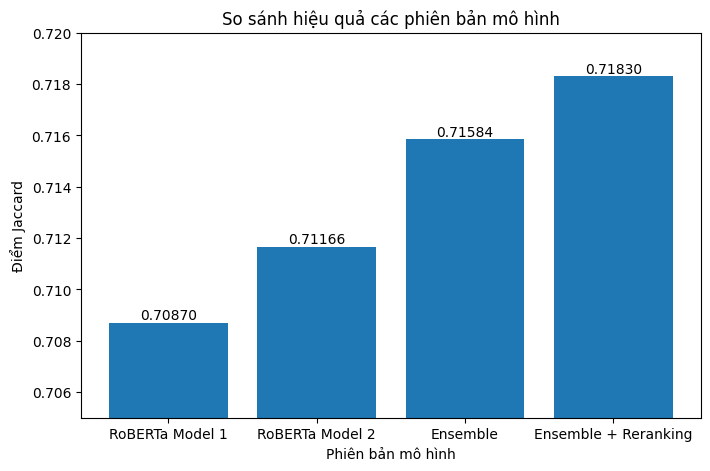

In [ ]:
import matplotlib.pyplot as plt

models = [
    "RoBERTa Model 1",
    "RoBERTa Model 2",
    "Ensemble",
    "Ensemble + Reranking"
]

jaccard_scores = [
    0.70870,
    0.71166,
    0.71584,
    0.71830
]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, jaccard_scores)

plt.xlabel("Phiên bản mô hình")
plt.ylabel("Điểm Jaccard")
plt.title("So sánh hiệu quả các phiên bản mô hình")

plt.xticks()
plt.ylim(0.705, 0.72)
plt.grid(False)

for bar, score in zip(bars, jaccard_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{score:.5f}",
        ha='center',
        va='bottom'
    )

plt.show()